In [ ]:
# Install required packages
!pip install gpytorch
!pip install seaborn
!pip install gym
!pip install stable-baselines3
!pip install pybullet
!pip install gymnasium
!pip install tensorflow
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/EVD/data/'

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9930789400974809643
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2549861101006787880
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from sklearn.mixture import GaussianMixture
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

# GP-specific imports
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO

# Load the dataset
df = pd.read_csv(data_path + "helsinki_ev_data_price.csv")
# Shuffle the dataset
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select the first 30,000 samples
df_subset = df_shuffled.head(30000)

# Define features and target
features_to_drop = ['Day','Time (HH:MM:SS)', 'Charging_Event (Count)', 'Charging_Demand (kWh)']
X = df_subset.drop(features_to_drop, axis=1)
y = df_subset['Charging_Demand (kWh)'].astype(float)  # Explicitly convert to float

# Identify categorical features and convert to numerical (GP doesn't handle categorical directly)
categorical_features = ['Region_ID']
X[categorical_features] = X[categorical_features].astype(int)  # Convert to integer codes

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = [col for col in X.columns if col not in categorical_features]
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Initialize k-fold cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define the Deep GP model components
class DeepGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution)
        super(DeepGPModel, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ThreeLayerDGPModel(torch.nn.Module):
    def __init__(self, inducing_points):
        super(ThreeLayerDGPModel, self).__init__()
        self.layer1 = DeepGPModel(inducing_points)
        self.layer2 = DeepGPModel(inducing_points)
        self.layer3 = DeepGPModel(inducing_points)

    def forward(self, x):
        h1 = self.layer1(x)
        h1_mean = h1.mean.unsqueeze(-1).expand(-1, x.size(-1))
        h2 = self.layer2(h1_mean)
        h2_mean = h2.mean.unsqueeze(-1).expand(-1, x.size(-1))
        output = self.layer3(h2_mean)
        return output

# Enhanced EVChargingEnv class modified for DGP
class EnhancedEVChargingEnv(gym.Env):
    def __init__(self, dgp_model, gp_likelihood, X_data, y_data):
        super(EnhancedEVChargingEnv, self).__init__()

        self.dgp_model = dgp_model
        self.gp_likelihood = gp_likelihood
        # Handle both DataFrame and array inputs
        self.X_data = X_data.values if hasattr(X_data, 'values') else X_data
        self.y_data = y_data.values if hasattr(y_data, 'values') else y_data
        self.current_idx = 0

        # Enhanced price parameters
        self.P_base = 0.25   # EUR/kWh
        self.P_min = 0.20
        self.P_max = 0.40
        self.alpha = 0.15

        # Initialize current_price
        self.current_price = self.P_base

        # Smoothing buffers
        self.price_memory = deque(maxlen=5)  # For action smoothing
        self.demand_memory = deque(maxlen=3) # For demand smoothing

        # Enhanced constraints
        self.max_daily_price_change = 0.10  # Max 10% daily variation
        self.target_load = np.mean(y_data)
        self.L_th = self.target_load * 1.5

        # Observation/action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, self.P_min]),
            high=np.array([np.inf, np.inf, 100, np.inf, np.inf, np.inf, self.P_max]),
            dtype=np.float32
        )
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Enhanced driver behavior model
        self.n_clusters = 3
        self.gmm = GaussianMixture(n_components=self.n_clusters)
        demands = self.y_data.reshape(-1, 1)
        self.gmm.fit(demands)
        self.gamma_k = np.array([0.8, 0.5, 0.3])  # Price sensitivity coefficients

        # Add demand tracking
        self.demand_history = []
        self.deviation_history = []
        self.target_load = np.mean(y_data)

    def _fit_driver_model(self):
        """Fit Gaussian Mixture Model to historical demand data"""
        demands = self.y_data.reshape(-1, 1)
        self.gmm.fit(demands)

    def _get_driver_response(self, price_change):
        """Simulate driver response to price change using GMM"""
        L_base, cluster = self.gmm.sample()
        L_base = L_base[0, 0]
        gamma = self.gamma_k[cluster[0]]
        L_t = L_base * (1 - gamma * price_change)
        return max(0, L_t)

    def _get_state(self, features):
        """Create state vector using DGP prediction"""
        features_tensor = torch.tensor(features.reshape(1, -1), dtype=torch.float32)
        if torch.cuda.is_available():
            features_tensor = features_tensor.cuda()

        self.dgp_model.eval()
        self.gp_likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.gp_likelihood(self.dgp_model(features_tensor))
            predicted_demand = observed_pred.mean.item()

        return np.array([
            predicted_demand, 1.0, 50.0, 20.0, 12.0, 1.0, self.current_price
        ], dtype=np.float32)

    def _enhanced_reward(self, current_demand, previous_demand, price_change, deviation):
        """New reward with demand growth penalty"""
        demand_growth_penalty = -0.5 * max(0, current_demand - previous_demand)
        reward = (
            -0.7 * (deviation ** 2) +
            -0.3 * (price_change ** 2) +
            -1.5 * max(0, current_demand - self.target_load) +
            demand_growth_penalty  # Penalize demand increases
        )
        if abs(price_change) > self.max_daily_price_change:
            reward -= 0.5 * (abs(price_change) - self.max_daily_price_change) ** 2
        return reward

    def step(self, action):
        # Action smoothing
        self.price_memory.append(action[0])
        smoothed_action = np.mean(self.price_memory)

        # Price adjustment
        price_adjustment = smoothed_action * 1.5
        new_price = self.P_base + self.alpha * price_adjustment
        new_price = np.clip(new_price, self.P_min, self.P_max)
        price_change = (new_price - self.current_price)/self.current_price

        # Get driver response
        price_change_pct = (new_price - self.P_base)/self.P_base
        actual_demand = self._get_driver_response(price_change_pct)
        self.demand_memory.append(actual_demand)

        # Calculate reward
        deviation = actual_demand - self.target_load
        reward = self._enhanced_reward(
            actual_demand,
            self.demand_memory[-2] if len(self.demand_memory) > 1 else actual_demand,
            price_change,
            deviation
        )

        # Store demand and deviation
        self.demand_history.append(actual_demand)
        self.deviation_history.append(deviation)

        # Update state
        self.current_idx = (self.current_idx + 1) % len(self.X_data)
        next_state = self._get_state(self.X_data[self.current_idx])
        next_state[-1] = new_price
        self.current_state = next_state
        self.current_price = new_price

        return next_state, reward, False, False, {
            'price': new_price,
            'demand': actual_demand,
            'deviation': deviation,
            'target_demand': self.target_load
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = 0
        self.current_state = self._get_state(self.X_data[self.current_idx])
        self.current_price = self.P_base
        return self.current_state, {}

# Initialize results storage
dgp_rl_results = {
    'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [],
    'train_mae': [], 'val_mae': [], 'train_rmse': [], 'val_rmse': [],
    'test_metrics': [], 'test_predictions': [], 'training_times': [],
    'epoch_counts': [], 'rl_rewards': [], 'rl_prices': [], 'rl_demands': []
}

# K-fold cross-validation loop with RL integration
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1}/{k_folds} ===")

    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Further split into train/val
    val_size = 0.15
    split_idx = int(len(X_train) * (1 - val_size))
    X_train_fold, X_val_fold = X_train[:split_idx], X_train[split_idx:]
    y_train_fold, y_val_fold = y_train[:split_idx], y_train[split_idx:]

    # Feature scaling
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    X_test_fold = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Initialize DGP model
    num_inducing_points = min(300, len(X_train_tensor))
    inducing_points = X_train_tensor[:num_inducing_points]
    model = ThreeLayerDGPModel(inducing_points)
    likelihood = GaussianLikelihood()

    # Move to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
        X_train_tensor = X_train_tensor.cuda()
        y_train_tensor = y_train_tensor.cuda()
        X_val_tensor = X_val_tensor.cuda()
        y_val_tensor = y_val_tensor.cuda()
        X_test_tensor = X_test_tensor.cuda()
        y_test_tensor = y_test_tensor.cuda()
        inducing_points = inducing_points.cuda()

    # Optimizer and loss - using only the final layer for the ELBO
    optimizer = torch.optim.Adam([
        {'params': model.layer1.parameters()},
        {'params': model.layer2.parameters()},
        {'params': model.layer3.parameters()},
        {'params': likelihood.parameters()}
    ], lr=0.01)
    mll = VariationalELBO(likelihood, model.layer3, num_data=X_train_tensor.size(0))

    # Time the training
    start_time = time.time()

    # Training loop
    train_losses = []
    val_losses = []
    train_r2 = []
    val_r2 = []
    train_mae = []
    val_mae = []
    train_rmse = []
    val_rmse = []

    best_val_loss = float('inf')
    patience = 300
    epochs_without_improvement = 0

    num_epochs = 500
    for epoch in tqdm(range(num_epochs), desc=f"Training Fold {fold + 1}"):
        # Training
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Training metrics
        with torch.no_grad():
            train_pred = output.mean
            train_r2.append(r2_score(y_train_tensor.cpu().numpy(), train_pred.cpu().numpy()))
            train_mae.append(mean_absolute_error(y_train_tensor.cpu().numpy(), train_pred.cpu().numpy()))
            train_rmse.append(np.sqrt(mean_squared_error(y_train_tensor.cpu().numpy(), train_pred.cpu().numpy())))

        # Validation
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            val_output = likelihood(model(X_val_tensor))
            val_loss = -mll(val_output, y_val_tensor).item()
            val_losses.append(val_loss)

            # Validation metrics
            val_pred = val_output.mean
            val_r2.append(r2_score(y_val_tensor.cpu().numpy(), val_pred.cpu().numpy()))
            val_mae.append(mean_absolute_error(y_val_tensor.cpu().numpy(), val_pred.cpu().numpy()))
            val_rmse.append(np.sqrt(mean_squared_error(y_val_tensor.cpu().numpy(), val_pred.cpu().numpy())))

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Store fold results
    dgp_rl_results['train_loss'].append(train_losses)
    dgp_rl_results['val_loss'].append(val_losses)
    dgp_rl_results['train_r2'].append(train_r2)
    dgp_rl_results['val_r2'].append(val_r2)
    dgp_rl_results['train_mae'].append(train_mae)
    dgp_rl_results['val_mae'].append(val_mae)
    dgp_rl_results['train_rmse'].append(train_rmse)
    dgp_rl_results['val_rmse'].append(val_rmse)

    # Test evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_output = likelihood(model(X_test_tensor))
        test_mean = test_output.mean
        test_mae = mean_absolute_error(y_test_tensor.cpu().numpy(), test_mean.cpu().numpy())
        test_rmse = np.sqrt(mean_squared_error(y_test_tensor.cpu().numpy(), test_mean.cpu().numpy()))
        test_r2 = r2_score(y_test_tensor.cpu().numpy(), test_mean.cpu().numpy())

        # Store test predictions
        test_predictions = test_mean.cpu().numpy()

    dgp_rl_results['test_predictions'].append(test_predictions)
    dgp_rl_results['test_metrics'].append({
        'mae': test_mae,
        'rmse': test_rmse,
        'r2': test_r2
    })

    end_time = time.time()
    fold_time = end_time - start_time
    dgp_rl_results['training_times'].append(fold_time)
    dgp_rl_results['epoch_counts'].append(len(train_losses))

    print(f"Training time for fold {fold + 1}: {fold_time:.2f} seconds")
    print(f"Number of epochs: {len(train_losses)}")

    print(f"\nFold {fold + 1} Test Metrics:")
    print(f"MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

    # Initialize RL environment with DGP model
    env = EnhancedEVChargingEnv(model, likelihood, X_val_fold, y_val_fold)
    check_env(env)

    # Enhanced SAC agent with modified parameters
    sac_agent = SAC(
        'MlpPolicy',
        env,
        verbose=1,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        learning_rate=3e-4,
        buffer_size=300000,
        batch_size=1024,
        ent_coef='auto',
        gamma=0.99,
        tau=0.005,
        policy_kwargs=dict(net_arch=[256, 256])
    )

    # Custom callback to track rewards and prices
    class CustomCallback(BaseCallback):
        def __init__(self, verbose=0):
            super(CustomCallback, self).__init__(verbose)
            self.rewards = []
            self.prices = []
            self.demands = []

        def _on_step(self) -> bool:
            info = self.locals['infos'][0]
            self.rewards.append(self.locals['rewards'][0])
            self.prices.append(info['price'])
            self.demands.append(info['demand'])
            return True

    callback = CustomCallback()

    # Train the SAC agent
    sac_agent.learn(total_timesteps=50000, callback=callback)

    # Store RL results
    dgp_rl_results['rl_rewards'].append(callback.rewards)
    dgp_rl_results['rl_prices'].append(callback.prices)
    dgp_rl_results['rl_demands'].append(callback.demands)

    print(f"\nRL Training completed for fold {fold + 1}")
    print(f"Average Reward: {np.mean(callback.rewards):.2f}")
    print(f"Price Range: {np.min(callback.prices):.3f}-{np.max(callback.prices):.3f} EUR/kWh")
    print(f"Average Demand: {np.mean(callback.demands):.2f} kWh")

# Calculate and display final results
avg_test_mae = np.mean([res['mae'] for res in dgp_rl_results['test_metrics']])
avg_test_rmse = np.mean([res['rmse'] for res in dgp_rl_results['test_metrics']])
avg_test_r2 = np.mean([res['r2'] for res in dgp_rl_results['test_metrics']])
avg_training_time = np.mean(dgp_rl_results['training_times'])
avg_epochs = np.mean(dgp_rl_results['epoch_counts'])

# Calculate RL metrics
all_prices = np.concatenate(dgp_rl_results['rl_prices'])
all_demands = np.concatenate(dgp_rl_results['rl_demands'])
price_elasticity = np.corrcoef(all_prices, all_demands)[0, 1]

print("\n=== Final DGP with RL Cross-Validation Results ===")
print(f"Average Test MAE across {k_folds} folds: {avg_test_mae:.4f}")
print(f"Average Test RMSE across {k_folds} folds: {avg_test_rmse:.4f}")
print(f"Average Test R² across {k_folds} folds: {avg_test_r2:.4f}")
print(f"\nAverage DGP training time: {avg_training_time:.2f} seconds")
print(f"Average number of epochs: {avg_epochs:.1f}")
print(f"\nRL Performance Summary:")
print(f"Average Price: {np.mean(all_prices):.3f} ± {np.std(all_prices):.3f} EUR/kWh")
print(f"Price Elasticity: {price_elasticity:.3f}")
print(f"Average Demand: {np.mean(all_demands):.2f} kWh")



# Save results function
def save_dgp_rl_results():
    results = {
        'avg_test_metrics': {
            'mae': avg_test_mae,
            'rmse': avg_test_rmse,
            'r2': avg_test_r2
        },
        'timing': {
            'per_fold_times': dgp_rl_results['training_times'],
            'average_time': avg_training_time,
            'per_fold_epochs': dgp_rl_results['epoch_counts'],
            'average_epochs': avg_epochs
        },
        'test_results': {
            'y_true': np.concatenate([y.iloc[test_idx] for _, test_idx in kf.split(X)]),
            'y_pred': np.concatenate(dgp_rl_results['test_predictions']),
            'metrics': dgp_rl_results['test_metrics']
        },
        'rl_results': {
            'rewards': dgp_rl_results['rl_rewards'],
            'prices': dgp_rl_results['rl_prices'],
            'demands': dgp_rl_results['rl_demands'],
            'price_stats': {
                'mean': np.mean(all_prices),
                'std': np.std(all_prices),
                'min': np.min(all_prices),
                'max': np.max(all_prices)
            },
            'elasticity': price_elasticity
        },
        'metadata': {
            'model_type': 'Deep Gaussian Process (3-layer) with SAC Pricing',
            'kernel': 'Matern 1.5',
            'env_parameters': {
                'P_base': 0.25,
                'P_min': 0.20,
                'P_max': 0.40,
                'gamma_k': [0.8, 0.5, 0.3]
            },
            'timestamp': pd.Timestamp.now().isoformat()
        }
    }

    with open(f'{data_path}saved_predictions/dgp_rl_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("DGP with RL results saved successfully!")

save_dgp_rl_results()


=== Fold 1/10 ===


Training Fold 1: 100%|██████████| 500/500 [02:44<00:00,  3.04it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 1: 164.66 seconds
Number of epochs: 500

Fold 1 Test Metrics:
MAE: 0.0904, RMSE: 0.1180, R²: 0.8515
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 1
Average Reward: -0.18
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.30 kWh

=== Fold 2/10 ===


Training Fold 2: 100%|██████████| 500/500 [02:44<00:00,  3.05it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 2: 164.05 seconds
Number of epochs: 500

Fold 2 Test Metrics:
MAE: 0.0873, RMSE: 0.1156, R²: 0.8482
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 2
Average Reward: -0.23
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.32 kWh

=== Fold 3/10 ===


Training Fold 3: 100%|██████████| 500/500 [02:42<00:00,  3.08it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 3: 162.53 seconds
Number of epochs: 500

Fold 3 Test Metrics:
MAE: 0.0885, RMSE: 0.1153, R²: 0.8563
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 3
Average Reward: -0.23
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 4/10 ===


Training Fold 4: 100%|██████████| 500/500 [02:41<00:00,  3.09it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 4: 161.99 seconds
Number of epochs: 500

Fold 4 Test Metrics:
MAE: 0.0896, RMSE: 0.1180, R²: 0.8438
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 4
Average Reward: -0.22
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.32 kWh

=== Fold 5/10 ===


Training Fold 5: 100%|██████████| 500/500 [02:43<00:00,  3.06it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 5: 163.30 seconds
Number of epochs: 500

Fold 5 Test Metrics:
MAE: 0.0881, RMSE: 0.1163, R²: 0.8513
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 5
Average Reward: -0.15
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.30 kWh

=== Fold 6/10 ===


Training Fold 6: 100%|██████████| 500/500 [02:43<00:00,  3.07it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 6: 163.11 seconds
Number of epochs: 500

Fold 6 Test Metrics:
MAE: 0.0858, RMSE: 0.1123, R²: 0.8570
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 6
Average Reward: -0.23
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 7/10 ===


Training Fold 7: 100%|██████████| 500/500 [02:43<00:00,  3.07it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 7: 163.05 seconds
Number of epochs: 500

Fold 7 Test Metrics:
MAE: 0.0881, RMSE: 0.1145, R²: 0.8622
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 7
Average Reward: -0.21
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.30 kWh

=== Fold 8/10 ===


Training Fold 8: 100%|██████████| 500/500 [02:43<00:00,  3.06it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 8: 163.68 seconds
Number of epochs: 500

Fold 8 Test Metrics:
MAE: 0.0872, RMSE: 0.1155, R²: 0.8673
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 8
Average Reward: -0.22
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Fold 9/10 ===


Training Fold 9: 100%|██████████| 500/500 [02:42<00:00,  3.07it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 9: 162.94 seconds
Number of epochs: 500

Fold 9 Test Metrics:
MAE: 0.0923, RMSE: 0.1225, R²: 0.8512
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 9
Average Reward: -0.17
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.29 kWh

=== Fold 10/10 ===


Training Fold 10: 100%|██████████| 500/500 [02:43<00:00,  3.06it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training time for fold 10: 163.16 seconds
Number of epochs: 500

Fold 10 Test Metrics:
MAE: 0.0900, RMSE: 0.1170, R²: 0.8520
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

RL Training completed for fold 10
Average Reward: -0.24
Price Range: 0.200-0.400 EUR/kWh
Average Demand: 0.31 kWh

=== Final DGP with RL Cross-Validation Results ===
Average Test MAE across 10 folds: 0.0887
Average Test RMSE across 10 folds: 0.1165
Average Test R² across 10 folds: 0.8541

Average DGP training time: 163.25 seconds
Average number of epochs: 500.0

RL Performance Summary:
Average Price: 0.371 ± 0.057 EUR/kWh
Price Elasticity: -0.197
Average Demand: 0.31 kWh
DGP with RL results saved successfully!


<Figure size 1600x600 with 0 Axes>

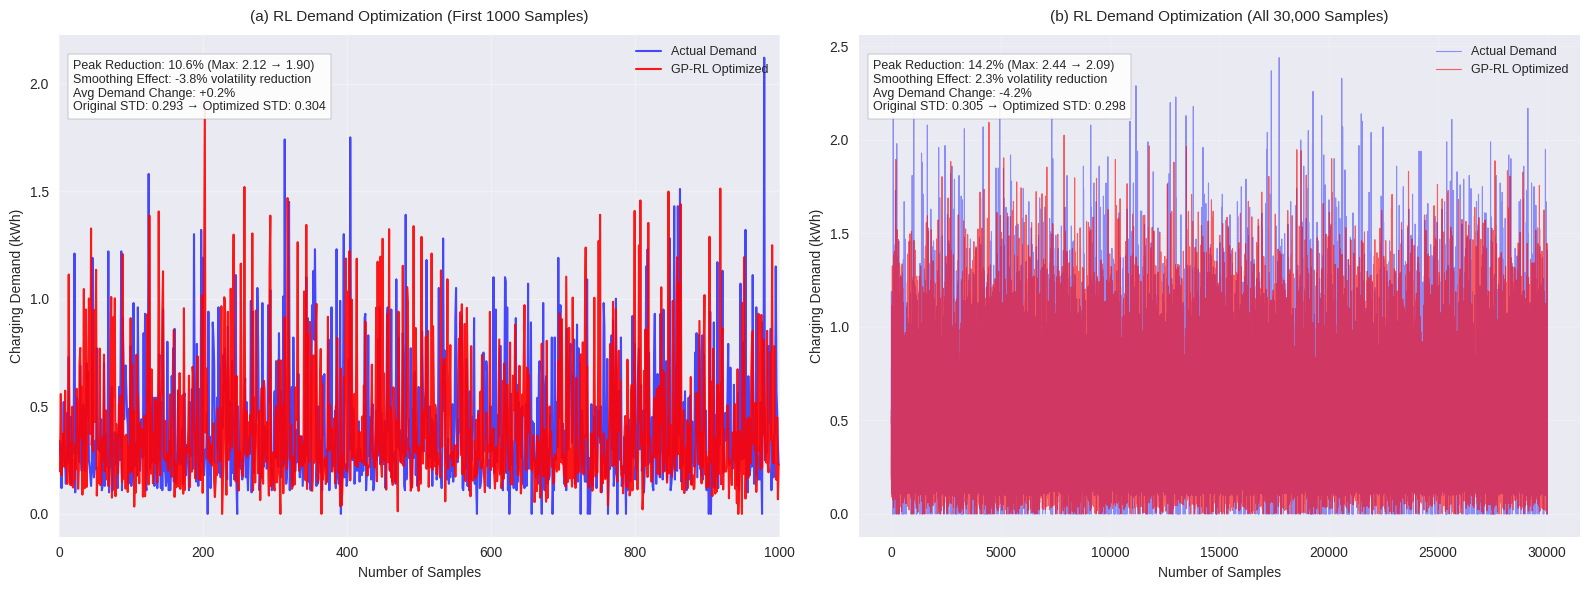


=== RL Optimization Statistics ===
Peak demand reduction: 14.2%
Average Price: 0.371 €/kWh
Price Elasticity: -0.197


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.figure(figsize=(16, 6))  # Adjusted figure size for 1 row of plots
plt.style.use('seaborn-v0_8')


with open('/content/drive/MyDrive/EVD/data/saved_predictions/dgp_rl_results.pkl', 'rb') as f:
    rl_results = pickle.load(f)

all_y_test_rl = rl_results['test_results']['y_true']

# Prepare data for all samples optimization plot
n_samples = len(all_y_test_rl)
all_original_demand_rl = []
all_rl_demands = []

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
X = pd.DataFrame(np.zeros((n_samples, 7)))

for fold, (_, val_idx) in enumerate(kf.split(X)):
    original_demand_fold = all_y_test_rl[val_idx]
    rl_demands_fold = rl_results['rl_results']['demands'][fold]
    min_length = min(len(original_demand_fold), len(rl_demands_fold))
    all_original_demand_rl.extend(original_demand_fold[:min_length])
    all_rl_demands.extend(rl_demands_fold[:min_length])


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# (a) RL first 1000 samples
axs[0].plot(all_y_test_rl[:1000], 'b-', alpha=0.7, label='Actual Demand', linewidth=1.5)
axs[0].plot(rl_results['rl_results']['demands'][0][:1000], 'r-', alpha=0.9, label='GP-RL Optimized', linewidth=1.5)
axs[0].set_xlabel('Number of Samples', fontsize=10)
axs[0].set_ylabel('Charging Demand (kWh)', fontsize=10)
axs[0].set_title('(a) RL Demand Optimization (First 1000 Samples)', fontsize=11, pad=10)
axs[0].legend(loc='upper right', fontsize=9, framealpha=1)
axs[0].grid(alpha=0.3)
axs[0].set_xlim(-1, 1001)

# Metrics for (a)
first_1000_actual_rl = all_y_test_rl[:1000]
first_1000_optimized_rl = rl_results['rl_results']['demands'][0][:1000]
peak_reduction_1000_rl = 100 * (1 - np.max(first_1000_optimized_rl)/np.max(first_1000_actual_rl))
original_std_1000_rl = np.std(first_1000_actual_rl)
optimized_std_1000_rl = np.std(first_1000_optimized_rl)
smoothing_1000_rl = 100 * (1 - (optimized_std_1000_rl/original_std_1000_rl))
avg_demand_change_1000_rl = 100 * ((np.mean(first_1000_optimized_rl) - np.mean(first_1000_actual_rl))/np.mean(first_1000_actual_rl))

metric_text_1000_rl = (
    f'Peak Reduction: {peak_reduction_1000_rl:.1f}% (Max: {np.max(first_1000_actual_rl):.2f} → {np.max(first_1000_optimized_rl):.2f})\n'
    f'Smoothing Effect: {smoothing_1000_rl:.1f}% volatility reduction\n'
    f'Avg Demand Change: {avg_demand_change_1000_rl:+.1f}%\n'
    f'Original STD: {original_std_1000_rl:.3f} → Optimized STD: {optimized_std_1000_rl:.3f}'
)
axs[0].text(0.02, 0.95, metric_text_1000_rl, transform=axs[0].transAxes,
          bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'),
          fontsize=9, verticalalignment='top')

# (b) RL all samples
axs[1].plot(all_original_demand_rl, 'b-', alpha=0.4, label='Actual Demand', linewidth=0.8)
axs[1].plot(all_rl_demands, 'r-', alpha=0.6, label='GP-RL Optimized', linewidth=0.8)
axs[1].set_xlabel('Number of Samples', fontsize=10)
axs[1].set_ylabel('Charging Demand (kWh)', fontsize=10)
axs[1].set_title('(b) RL Demand Optimization (All 30,000 Samples)', fontsize=11, pad=10)
axs[1].legend(loc='upper right', fontsize=9, framealpha=1)
axs[1].grid(alpha=0.2)

# Metrics for (b)
peak_reduction_rl = 100 * (1 - np.max(all_rl_demands)/np.max(all_original_demand_rl))
original_std_rl = np.std(all_original_demand_rl)
optimized_std_rl = np.std(all_rl_demands)
smoothing_rl = 100 * (1 - (optimized_std_rl/original_std_rl))
avg_demand_change_rl = 100 * ((np.mean(all_rl_demands) - np.mean(all_original_demand_rl))/np.mean(all_original_demand_rl))

metric_text_rl = (
    f'Peak Reduction: {peak_reduction_rl:.1f}% (Max: {np.max(all_original_demand_rl):.2f} → {np.max(all_rl_demands):.2f})\n'
    f'Smoothing Effect: {smoothing_rl:.1f}% volatility reduction\n'
    f'Avg Demand Change: {avg_demand_change_rl:+.1f}%\n'
    f'Original STD: {original_std_rl:.3f} → Optimized STD: {optimized_std_rl:.3f}'
)
axs[1].text(0.02, 0.95, metric_text_rl, transform=axs[1].transAxes,
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'),
         fontsize=9, verticalalignment='top')

# Save and show
plt.tight_layout()
plt.savefig('rl_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print optimization statistics
print("\n=== RL Optimization Statistics ===")
print(f"Peak demand reduction: {peak_reduction_rl:.1f}%")
print(f"Average Price: {rl_results['rl_results']['price_stats']['mean']:.3f} €/kWh")
print(f"Price Elasticity: {rl_results['rl_results']['elasticity']:.3f}")